In [1]:
import uproot
import matplotlib.pyplot as plt
import vector
import awkward as ak
import hist
import numpy as np
import ROOT
import itertools


treename="zcounting/tree"
filename_ntuple="/eos/cms/store/group/comm_luminosity/ZCounting/2022/MC/crab/DYJetsToLL_M_50_LO_FlatPU0to70_Run3Winter22.root"
f1=uproot.open(filename_ntuple)
f1.keys()

['countEvents;1',
 'countEvents/unweightedEvents;1',
 'countEvents/weightedEvents;1',
 'pileupMCTemplateMaker;1',
 'pileupMCTemplateMaker/MC_TrueNInt_outOfTimeEarly;1',
 'pileupMCTemplateMaker/MC_TrueNInt_inTime;1',
 'pileupMCTemplateMaker/MC_TrueNInt_outOfTimeLate;1',
 'zcounting;1',
 'zcounting/tree;1']

In [2]:
data=uproot.open(filename_ntuple+":"+treename)

In [3]:
# data with identification cuts 

electron_kine=data.arrays(["Electron_pt","Electron_eta","Electron_dxyPV","Electron_dEtaInSeed","Electron_deltaPhiSuperClusterTrackAtVtx","Electron_superclusterEnergy",
                          "Electron_dzPV","Electron_hadronicOverEm","Electron_eSuperClusterOverP","Electron_phi","Electron_charge","Electron_ecalEnergy","Electron_triggerBits","Electron_full5x5_sigmaIetaIeta","Electron_gsfTrackMissingInnerHits"]
,"(Electron_pt>30)&(abs(Electron_eta)<2.5)&(Electron_full5x5_sigmaIetaIeta<0.0106)&(abs(Electron_dEtaInSeed)<0.0032)&(abs(Electron_deltaPhiSuperClusterTrackAtVtx)<0.0547)&(Electron_gsfTrackMissingInnerHits<=1)&(decayMode==11)")


In [3]:
# data without identification cuts 

electron_gsf=data.arrays(["Electron_pt","Electron_eta","Electron_dxyPV","Electron_dEtaInSeed","Electron_deltaPhiSuperClusterTrackAtVtx","Electron_superclusterEnergy",
                          "Electron_dzPV","Electron_hadronicOverEm","Electron_gsfTrackMissingInnerHits","Electron_phi","Electron_charge","Electron_ecalEnergy","Electron_triggerBits","Electron_full5x5_sigmaIetaIeta"]
,"(Electron_pt>30)&(abs(Electron_eta)<2.5)&(decayMode==11)")

In [4]:
# data with id cal

electron_idcal = data.arrays(["Electron_pt","Electron_eta","Electron_dxyPV","Electron_dEtaInSeed","Electron_deltaPhiSuperClusterTrackAtVtx","Electron_superclusterEnergy",
                         "Electron_dzPV","Electron_hadronicOverEm","Electron_eSuperClusterOverP","Electron_phi","Electron_charge","Electron_ecalEnergy","Electron_triggerBits","Electron_full5x5_sigmaIetaIeta","Electron_gsfTrackMissingInnerHits"]
,"(Electron_pt>30)&(abs(Electron_eta)<2.5)&(Electron_full5x5_sigmaIetaIeta<0.0106)&(Electron_hadronicOverEm<(0.046+(1.16/Electron_superclusterEnergy)))&(decayMode==11)")

In [5]:
# data with id trak

electron_idtrk = data.arrays(["Electron_pt","Electron_eta","Electron_dxyPV","Electron_dEtaInSeed","Electron_deltaPhiSuperClusterTrackAtVtx","Electron_superclusterEnergy",
                         "Electron_dzPV","Electron_hadronicOverEm","Electron_eSuperClusterOverP","Electron_phi","Electron_charge","Electron_ecalEnergy","Electron_triggerBits","Electron_full5x5_sigmaIetaIeta","Electron_gsfTrackMissingInnerHits"]
,"(Electron_pt>30)&(abs(Electron_eta)<2.5)&(Electron_gsfTrackMissingInnerHits<=1)&(decayMode==11)")

In [15]:
def produce_pairs(electron_idtrk,electron_gsf):
    
    Echarge = ak.cartesian([electron_idtrk["Electron_charge"],electron_gsf["Electron_charge"]])
    lefts, rights = ak.unzip(Echarge)
    mask_Electron = lefts*rights == -1 # they must have opposite charge
    
    
    # select paris of opposite charged electons
    
    p_pt = ak.flatten( ak.cartesian([electron_idtrk["Electron_pt"],electron_gsf["Electron_pt"]])[mask_Electron]) 
    p_eta = ak.flatten(ak.cartesian([electron_idtrk["Electron_eta"],electron_gsf["Electron_eta"]])[mask_Electron])
    p_phi = ak.flatten(ak.cartesian([electron_idtrk["Electron_phi"],electron_gsf["Electron_phi"]])[mask_Electron])
    p_energy = ak.flatten(ak.cartesian([electron_idtrk["Electron_ecalEnergy"],electron_gsf["Electron_ecalEnergy"]])[mask_Electron]) 
    p_full = ak.flatten(ak.cartesian([electron_idtrk["Electron_full5x5_sigmaIetaIeta"],electron_gsf["Electron_full5x5_sigmaIetaIeta"]])[mask_Electron])
    p_dxy = ak.flatten(ak.cartesian([electron_idtrk["Electron_dxyPV"],electron_gsf["Electron_dxyPV"]])[mask_Electron])
    p_dz = ak.flatten(ak.cartesian([electron_idtrk["Electron_dzPV"],electron_gsf["Electron_dzPV"]])[mask_Electron])
    p_detaseed = ak.flatten(ak.cartesian([electron_idtrk["Electron_dEtaInSeed"],electron_gsf["Electron_dEtaInSeed"]])[mask_Electron])
    p_dphin = ak.flatten(ak.cartesian([electron_idtrk["Electron_deltaPhiSuperClusterTrackAtVtx"],electron_gsf["Electron_deltaPhiSuperClusterTrackAtVtx"]])[mask_Electron])
    p_hlt = ak.flatten(ak.cartesian([electron_idtrk["Electron_triggerBits"],electron_gsf["Electron_triggerBits"]])[mask_Electron])
    p_track = ak.flatten(ak.cartesian([electron_idtrk["Electron_gsfTrackMissingInnerHits"],electron_gsf["Electron_gsfTrackMissingInnerHits"]])[mask_Electron])

    #  zcandidate
   
    l_pt, r_pt = ak.unzip(p_pt)
    l_eta, r_eta = ak.unzip(p_eta)
    l_phi, r_phi = ak.unzip(p_phi)
    l_energy, r_energy = ak.unzip(p_energy)
    
    # This variable is only for correlation analysis
    l_full , r_full = ak.unzip(p_full)
    l_dxy, r_dxy = ak.unzip(p_dxy)
    l_dz, r_dz = ak.unzip(p_dz)
    l_detaseed, r_detaseed = ak.unzip(p_detaseed)
    l_dphin, r_dphin = ak.unzip(p_dphin)  
    l_hlt , r_hlt = ak.unzip(p_hlt)  
    l_track , r_track = ak.unzip(p_track) 
        
    return l_pt,l_eta,l_phi,l_energy,l_full,l_dxy,l_dz,l_detaseed,l_dphin,l_hlt,l_track,r_pt,r_eta,r_phi,r_energy,r_full,r_dxy,r_dz,r_detaseed,r_dphin,r_hlt,r_track


In [ ]:
l_pt,l_eta,l_phi,l_energy,l_full,l_dxy,l_dz,l_detaseed,l_dphin,l_hlt,l_track,r_pt,r_eta,r_phi,r_energy,r_full,r_dxy,r_dz,r_detaseed,r_dphin,r_hlt,r_track=produce_pairs(electron_idtrk,electron_gsf)

print("l_pt",l_pt)
print("len",len(l_pt))
print("l_phi",l_phi)
print("l_eta",l_eta)
print("l_energy",l_energy)
print("r_track",r_track)

    
e1 = vector. VectorNumpy4D(
        {
            "x":l_pt,
            "y":l_phi,
            "z":l_eta,
            "t":l_energy,
        }
)

e2 = vector. VectorNumpy4D(
         {
            "x":r_pt,
            "y":r_phi,
            "z":r_eta,
            "t":r_energy,
             
             
             
         }
)

print("e1",e1)

print("e2",e2)


zcond = e1 + e2

zcondmag=zcond.mag
 


z=[]
i=1
for i in range (1,len(zcondmag)):
    if abs(zcondmag[i] - 91.19)<15:
        z.append(abs(zcondmag[i]))

        
j=0
sub=[]
for j in range(len(z)):
    x =np.array(np.where(zcondmag==z[j]))
    sub.append(x)
o = ak.flatten(sub)

flat_list = list(itertools.chain.from_iterable(o))       
        

l_pt [39.8, 49.2, 42.4, 45.2, 30.8, 60.6, 48.6, ... 38, 39.2, 43.6, 31.7, 41.1, 40.8]
len 1522824
l_phi [-0.88, 2.53, 2.71, -0.322, -2.07, 1.81, ... -2.21, 1.27, -2.35, 0.915, -3.03, 0.259]
l_eta [1.97, 1.47, 1.18, 1.6, 0.369, -0.627, ... 1.23, 0.113, 1.09, -0.172, 2.02, 2.23]
l_energy [144, 113, 76.1, 115, 32.9, 73, 79.5, 145, ... 159, 71.4, 39.6, 71.8, 32.2, 158, 192]
r_track [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
e1 [(39.78707504, -0.87960351,  1.96633005, 143.87739563)
 (49.19788742,  2.52822018,  1.47334313, 113.12696075)
 (42.44467163,  2.70772266,  1.18041861,  76.07386017) ...
 (31.65058708,  0.9147613 , -0.17239177,  32.1922226 )
 (41.14505386, -3.02791071,  2.02013087, 158.0274353 )
 (40.82894135,  0.25907767,  2.22651291, 191.75566101)]
e2 [(49.19788742,  2.52822018, 1.47334313, 113.12696075)
 (39.78707504, -0.87960351, 1.96633005, 143.87739563)
 (45.22899628, -0.32181451, 1.60066295, 115.46871948) ...
 (43.55558014, -2.34752226

In [9]:
i=0
trs=[]
for i in range(len(flat_list)):
    r = np.array(np.where((r_track[flat_list[i]])<=1))
    trs.append(r)    
    
nf = len(trs)-len(flat_list)
print("npass",len(trs))
print("nfail",nf)

effidtr = (len(trs)/(len(trs)+nf))
print("IDtrack|gsf",effidtr)

npass 2261523
nfail 0
IDtrack|gsf 1.0


In [13]:
def produce_pairs(electron_iboth,electron_idtrk):
    
    Echarge = ak.cartesian([electron_idboth["Electron_charge"],electron_idtrk["Electron_charge"]])
    lefts, rights = ak.unzip(Echarge)
    mask_Electron = lefts*rights == -1 # they must have opposite charge
    
    
    # select paris of opposite charged electons
    
    p_pt = ak.flatten( ak.cartesian([electron_idboth["Electron_pt"],electron_idtrk["Electron_pt"]])[mask_Electron]) 
    p_eta = ak.flatten(ak.cartesian([electron_idboth["Electron_eta"],electron_idtrk["Electron_eta"]])[mask_Electron])
    p_phi = ak.flatten(ak.cartesian([electron_idboth["Electron_phi"],electron_idtrk["Electron_phi"]])[mask_Electron])
    p_energy = ak.flatten(ak.cartesian([electron_idboth["Electron_ecalEnergy"],electron_idtrk["Electron_ecalEnergy"]])[mask_Electron]) 
    p_full = ak.flatten(ak.cartesian([electron_idboth["Electron_full5x5_sigmaIetaIeta"],electron_idtrk["Electron_full5x5_sigmaIetaIeta"]])[mask_Electron])
    p_dxy = ak.flatten(ak.cartesian([electron_idboth["Electron_dxyPV"],electron_idtrk["Electron_dxyPV"]])[mask_Electron])
    p_dz = ak.flatten(ak.cartesian([electron_idboth["Electron_dzPV"],electron_idtrk["Electron_dzPV"]])[mask_Electron])
    p_detaseed = ak.flatten(ak.cartesian([electron_idboth["Electron_dEtaInSeed"],electron_idtrk["Electron_dEtaInSeed"]])[mask_Electron])
    p_dphin = ak.flatten(ak.cartesian([electron_idboth["Electron_deltaPhiSuperClusterTrackAtVtx"],electron_idtrk["Electron_deltaPhiSuperClusterTrackAtVtx"]])[mask_Electron])
    p_hlt = ak.flatten(ak.cartesian([electron_idboth["Electron_triggerBits"],electron_idtrk["Electron_triggerBits"]])[mask_Electron])
    p_track = ak.flatten(ak.cartesian([electron_idboth["Electron_gsfTrackMissingInnerHits"],electron_idtrk["Electron_gsfTrackMissingInnerHits"]])[mask_Electron])
    p_hovere = ak.flatten(ak.cartesian([electron_idboth["Electron_hadronicOverEm"],electron_idtrk["Electron_hadronicOverEm"]])[mask_Electron])
    p_super =  ak.flatten( ak.cartesian([electron_idboth["Electron_superclusterEnergy"],electron_idtrk["Electron_superclusterEnergy"]])[mask_Electron]) 
    p_esuper = ak.flatten( ak.cartesian([electron_idboth["Electron_eSuperClusterOverP"],electron_idtrk["Electron_eSuperClusterOverP"]])[mask_Electron])
    #  zcandidate
   
    l_pt, r_pt = ak.unzip(p_pt)
    l_eta, r_eta = ak.unzip(p_eta)
    l_phi, r_phi = ak.unzip(p_phi)
    l_energy, r_energy = ak.unzip(p_energy)
    
    # This variable is only for correlation analysis
    l_full , r_full = ak.unzip(p_full)
    l_dxy, r_dxy = ak.unzip(p_dxy)
    l_dz, r_dz = ak.unzip(p_dz)
    l_detaseed, r_detaseed = ak.unzip(p_detaseed)
    l_dphin, r_dphin = ak.unzip(p_dphin)  
    l_hlt , r_hlt = ak.unzip(p_hlt)  
    l_track , r_track = ak.unzip(p_track)
    l_hover , r_hover = ak.unzip(p_hovere) 
    l_super , r_super = ak.unzip(p_super)
    l_esuper , r_esuper = ak.unzip(p_esuper)
    
    return l_pt,l_eta,l_phi,l_energy,l_full,l_dxy,l_dz,l_detaseed,l_dphin,l_hlt,l_track,l_hover,l_super,l_esuper,r_pt,r_eta,r_phi,r_energy,r_full,r_dxy,r_dz,r_detaseed,r_dphin,r_hlt,r_track,r_hover,r_super,r_esuper


In [14]:
l_pt,l_eta,l_phi,l_energy,l_full,l_dxy,l_dz,l_detaseed,l_dphin,l_hlt,l_track,l_hover,l_super,l_esuper,r_pt,r_eta,r_phi,r_energy,r_full,r_dxy,r_dz,r_detaseed,r_dphin,r_hlt,r_track,r_hover,r_super,r_esuper=produce_pairs(electron_idboth,electron_idtrk)

print("l_pt",l_pt)
print("len",len(l_pt))
print("l_phi",l_phi)
print("l_eta",l_eta)
print("l_energy",l_energy)
print("r_track",r_track)
print("r_hover",r_hover)
    
e1 = vector. VectorNumpy4D(
        {
            "x":l_pt,
            "y":l_phi,
            "z":l_eta,
            "t":l_energy,
        }
)

e2 = vector. VectorNumpy4D(
         {
            "x":r_pt,
            "y":r_phi,
            "z":r_eta,
            "t":r_energy,
             
             
             
         }
)

print("e1",e1)

print("e2",e2)


zcond = e1 + e2

zcondmag=zcond.mag
 


z=[]
i=1
for i in range (1,len(zcondmag)):
    if abs(zcondmag[i] - 91.19)<15:
        z.append(abs(zcondmag[i]))

        
j=0
sub=[]
for j in range(len(z)):
    x =np.array(np.where(zcondmag==z[j]))
    sub.append(x)
o = ak.flatten(sub)

flat_list = list(itertools.chain.from_iterable(o))       
        

l_pt [39.8, 49.2, 42.4, 30.8, 60.6, 48.6, 35.3, ... 38, 39.2, 43.6, 31.7, 41.1, 40.8]
len 1394442
l_phi [-0.88, 2.53, 2.71, -2.07, 1.81, 0.96, ... -2.21, 1.27, -2.35, 0.915, -3.03, 0.259]
l_eta [1.97, 1.47, 1.18, 0.369, -0.627, 1.1, ... 1.23, 0.113, 1.09, -0.172, 2.02, 2.23]
l_energy [144, 113, 76.1, 32.9, 73, 79.5, 145, ... 98.4, 71.4, 39.6, 71.8, 32.2, 158, 192]
r_track [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
r_hover [0.0135, 0.0146, 0.0211, 0.0542, 0, 0.0565, ... 0, 0.023, 0.0152, 0, 0.0065, 0.0111]
e1 [(39.78707504, -0.87960351,  1.96633005, 143.87739563)
 (49.19788742,  2.52822018,  1.47334313, 113.12696075)
 (42.44467163,  2.70772266,  1.18041861,  76.07386017) ...
 (31.65058708,  0.9147613 , -0.17239177,  32.1922226 )
 (41.14505386, -3.02791071,  2.02013087, 158.0274353 )
 (40.82894135,  0.25907767,  2.22651291, 191.75566101)]
e2 [(49.19788742,  2.52822018, 1.47334313, 113.12696075)
 (39.78707504, -0.87960351, 1.96633005, 143.8773956

In [14]:
ii=0
trss=[]
for ii in range(len(flat_list)):
    if(((r_full[flat_list[ii]])<0.0106) & ((r_hover[flat_list[ii]])<(0.046+(1.16/r_super[flat_list[ii]])))):
        trss.append(flat_list[ii])    
    
    
nfa = len(flat_list)-len(trss)
print("Npass",len(trss))
print("Nfail",nfa)

effidcal = (len(trss)/(len(trss)+nfa))
print("IDcal|trk",effidcal)

Npass 691442
Nfail 676760
IDcal|trk 0.5053654358055316


In [18]:
s=0
tr=[]
for s in range(len(flat_list)):
    if(((r_dphin[flat_list[s]])<0.0547) & ((r_detaseed[flat_list[s]])<0.0032) & (((1.0-r_esuper[flat_list[s]])/(r_energy[flat_list[s]]))<0.184)):
        tr.append(flat_list[s])    
    
    
nfaa = len(flat_list)-len(tr)
print("Npass",len(tr))
print("Nfail",nfaa)

effidbo = (len(tr)/(len(tr)+nfaa))
print("IDboth|trk",effidbo)

Npass 1956409
Nfail 42455
IDboth|trk 0.9787604359276069


In [5]:
# data with id both

electron_idboth = data.arrays(["Electron_pt","Electron_eta","Electron_dxyPV","Electron_dEtaInSeed","Electron_deltaPhiSuperClusterTrackAtVtx","Electron_superclusterEnergy",
                         "Electron_dzPV","Electron_hadronicOverEm","Electron_eSuperClusterOverP","Electron_phi","Electron_charge","Electron_ecalEnergy","Electron_triggerBits","Electron_full5x5_sigmaIetaIeta","Electron_gsfTrackMissingInnerHits"]
,"(Electron_pt>30)&(abs(Electron_eta)<2.5)&(abs(Electron_deltaPhiSuperClusterTrackAtVtx)<0.0547)&(abs(Electron_dEtaInSeed)<0.0032)&(abs((1.0-Electron_eSuperClusterOverP)/(Electron_ecalEnergy))<0.184)&(decayMode==11)")

In [11]:
def produce_pairs(electron_idcal,electron_idboth):
    
    Echarge = ak.cartesian([electron_idcal["Electron_charge"],electron_idboth["Electron_charge"]])
    lefts, rights = ak.unzip(Echarge)
    mask_Electron = lefts*rights == -1 # they must have opposite charge
    
    
    # select paris of opposite charged electons
    
    p_pt = ak.flatten( ak.cartesian([electron_idcal["Electron_pt"],electron_idboth["Electron_pt"]])[mask_Electron]) 
    p_eta = ak.flatten(ak.cartesian([electron_idcal["Electron_eta"],electron_idboth["Electron_eta"]])[mask_Electron])
    p_phi = ak.flatten(ak.cartesian([electron_idcal["Electron_phi"],electron_idboth["Electron_phi"]])[mask_Electron])
    p_energy = ak.flatten(ak.cartesian([electron_idcal["Electron_ecalEnergy"],electron_idboth["Electron_ecalEnergy"]])[mask_Electron]) 
    p_full = ak.flatten(ak.cartesian([electron_idcal["Electron_full5x5_sigmaIetaIeta"],electron_idboth["Electron_full5x5_sigmaIetaIeta"]])[mask_Electron])
    p_dxy = ak.flatten(ak.cartesian([electron_idcal["Electron_dxyPV"],electron_idboth["Electron_dxyPV"]])[mask_Electron])
    p_dz = ak.flatten(ak.cartesian([electron_idcal["Electron_dzPV"],electron_idboth["Electron_dzPV"]])[mask_Electron])
    p_detaseed = ak.flatten(ak.cartesian([electron_idcal["Electron_dEtaInSeed"],electron_idboth["Electron_dEtaInSeed"]])[mask_Electron])
    p_dphin = ak.flatten(ak.cartesian([electron_idcal["Electron_deltaPhiSuperClusterTrackAtVtx"],electron_idboth["Electron_deltaPhiSuperClusterTrackAtVtx"]])[mask_Electron])
    p_hlt = ak.flatten(ak.cartesian([electron_idcal["Electron_triggerBits"],electron_idboth["Electron_triggerBits"]])[mask_Electron])
    p_track = ak.flatten(ak.cartesian([electron_idcal["Electron_gsfTrackMissingInnerHits"],electron_idboth["Electron_gsfTrackMissingInnerHits"]])[mask_Electron])
    p_hovere = ak.flatten(ak.cartesian([electron_idcal["Electron_hadronicOverEm"],electron_idboth["Electron_hadronicOverEm"]])[mask_Electron])
    p_super =  ak.flatten( ak.cartesian([electron_idcal["Electron_superclusterEnergy"],electron_idboth["Electron_superclusterEnergy"]])[mask_Electron]) 
    p_esuper = ak.flatten( ak.cartesian([electron_idcal["Electron_eSuperClusterOverP"],electron_idboth["Electron_eSuperClusterOverP"]])[mask_Electron])
    
    #  zcandidate
   
    l_pt, r_pt = ak.unzip(p_pt)
    l_eta, r_eta = ak.unzip(p_eta)
    l_phi, r_phi = ak.unzip(p_phi)
    l_energy, r_energy = ak.unzip(p_energy)
    
    # This variable is only for correlation analysis
    l_full , r_full = ak.unzip(p_full)
    l_dxy, r_dxy = ak.unzip(p_dxy)
    l_dz, r_dz = ak.unzip(p_dz)
    l_detaseed, r_detaseed = ak.unzip(p_detaseed)
    l_dphin, r_dphin = ak.unzip(p_dphin)  
    l_hlt , r_hlt = ak.unzip(p_hlt)  
    l_track , r_track = ak.unzip(p_track)
    l_hovere , r_hovere = ak.unzip(p_hovere) 
    l_super , r_super = ak.unzip(p_super)
    l_esuper , r_esuper = ak.unzip(p_esuper)
    
    return l_pt,l_eta,l_phi,l_energy,l_full,l_dxy,l_dz,l_detaseed,l_dphin,l_hlt,l_track,l_hovere,l_super,l_esuper,r_pt,r_eta,r_phi,r_energy,r_full,r_dxy,r_dz,r_detaseed,r_dphin,r_hlt,r_track,r_hovere,r_super,r_esuper


In [12]:
l_pt,l_eta,l_phi,l_energy,l_full,l_dxy,l_dz,l_detaseed,l_dphin,l_hlt,l_track,l_hovere,l_super,l_esuper,r_pt,r_eta,r_phi,r_energy,r_full,r_dxy,r_dz,r_detaseed,r_dphin,r_hlt,r_track,r_hovere,r_super,r_esuper=produce_pairs(electron_idcal,electron_idboth)

print("l_pt",l_pt)
print("len",len(l_pt))
print("l_phi",l_phi)
print("l_eta",l_eta)
print("l_energy",l_energy)
print("r_track",r_track)
print("r_hover",r_hovere)
    
e1 = vector. VectorNumpy4D(
        {
            "x":l_pt,
            "y":l_phi,
            "z":l_eta,
            "t":l_energy,
        }
)

e2 = vector. VectorNumpy4D(
         {
            "x":r_pt,
            "y":r_phi,
            "z":r_eta,
            "t":r_energy,
             
             
             
         }
)

print("e1",e1)

print("e2",e2)


zcond = e1 + e2

zcondmag=zcond.mag
 


z=[]
i=1
for i in range (1,len(zcondmag)):
    if abs(zcondmag[i] - 91.19)<15:
        z.append(abs(zcondmag[i]))

        
j=0
sub=[]
for j in range(len(z)):
    x =np.array(np.where(zcondmag==z[j]))
    sub.append(x)
o = ak.flatten(sub)

flat_list = list(itertools.chain.from_iterable(o))       
        

l_pt [49.2, 30.8, 60.6, 48.6, 36.9, 54.3, 46.2, ... 34.3, 34.1, 38, 39.2, 43.6, 31.7]
len 960287
l_phi [2.53, -2.07, 1.81, 0.96, 0.0229, 1.32, ... 2.21, -0.749, -2.21, 1.27, -2.35, 0.915]
l_eta [1.47, 0.369, -0.627, 1.1, -0.111, 1.02, ... 0.404, -1.19, 1.23, 0.113, 1.09, -0.172]
l_energy [113, 32.9, 73, 79.5, 36.9, 84.8, 95, ... 46.3, 36.5, 60.2, 71.4, 39.6, 71.8, 32.2]
r_track [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
r_hover [0.0146, 0.0542, 0, 0.0565, 0.000924, 0.0104, 0, ... 0, 0.00699, 0, 0.023, 0.0152, 0]
e1 [(49.19788742,  2.52822018,  1.47334313, 113.12696075)
 (30.83180618, -2.07312012,  0.36901924,  32.86407089)
 (60.64469528,  1.81405818, -0.62652272,  73.03495026) ...
 (39.20230865,  1.26640344,  0.11266815,  39.64342117)
 (43.55558014, -2.34752226,  1.0864532 ,  71.84860992)
 (31.65058708,  0.9147613 , -0.17239177,  32.1922226 )]
e2 [(39.78707504, -0.87960351,  1.96633005, 143.87739563)
 (60.64469528,  1.81405818, -0.62652272,  7

In [13]:
iii=0
trsss=[]
for iii in range(len(flat_list)):
    if(((r_full[flat_list[iii]])<0.0106) & ((r_hovere[flat_list[iii]])<(0.046+(1.16/(r_super[flat_list[iii]]))<0.184))):
        trsss.append(flat_list[iii])    
    
    
nfa = len(flat_list)-len(trsss)
print("Npass",len(trsss))
print("Nfail",nfa)

effidboth= (len(trsss)/(len(trsss)+nfa))
print("IDboth|cal",effidboth)


Npass 1171499
Nfail 120757
IDboth|cal 0.906553345467152


In [ ]:
 0.906553345467152

In [4]:
eventId = data.arrays(["eventNumber"])
nPileup = data.arrays(["nPU"])
nVertex = data.arrays(["nPV"])

In [5]:
import vector
vector.register_awkward()
myElectron = ak.zip({
        "pt" : electron_kine["Electron_pt"],
        "eta" :electron_kine["Electron_eta"],
        "phi" : electron_kine["Electron_phi"],
        "energy" : electron_kine["Electron_ecalEnergy"],
}, with_name="Momentum4D")
pairs = ak.combinations(myElectron, 2)
e1, e2 = ak.unzip(pairs)
zmass = abs((e1+e2).mass - 91)
myEvent = ak.zip({
        "Id": eventId["eventNumber"],
        "charge": ak.combinations(electron_kine["Electron_charge"],2),
        "pt" : ak.combinations(electron_kine["Electron_pt"],2),
        "eta" :ak.combinations(electron_kine["Electron_eta"],2),
        "phi" : ak.combinations(electron_kine["Electron_phi"],2),
        "energy" : ak.combinations(electron_kine["Electron_ecalEnergy"],2),
        "full" : ak.combinations(electron_kine["Electron_full5x5_sigmaIetaIeta"],2),
        "dxy" : ak.combinations(electron_kine["Electron_dxyPV"],2),
        "dz" : ak.combinations(electron_kine["Electron_dzPV"],2),
        "detaseed" : ak.combinations(electron_kine["Electron_dEtaInSeed"],2),
        "dphin" : ak.combinations(electron_kine["Electron_deltaPhiSuperClusterTrackAtVtx"],2),
        "hlt" : ak.combinations(electron_kine["Electron_triggerBits"],2),
        "Zmass" : zmass,
        "nPu" : nPileup["nPU"],
        "nPv" : nVertex["nPV"],
    }, with_name="myInfo")
lefts, rights = ak.unzip(myEvent.charge)
mask_Electron = lefts*rights == -1
selEvent = ak.flatten(myEvent[mask_Electron])
#selEvent = selEvent[selEvent.Zmass < 15]
l_pt, r_pt = ak.unzip(selEvent["pt"])
l_eta, r_eta = ak.unzip(selEvent["eta"])
l_phi, r_phi = ak.unzip(selEvent["phi"])
l_energy, r_energy = ak.unzip(selEvent["energy"])
l_hlt, r_hlt = ak.unzip(selEvent["hlt"])

c = selEvent["nPu"]
d = selEvent["nPv"]
h = selEvent["Id"]
print("npv",selEvent["nPv"])
print(len(selEvent["nPv"]))
print("npu",selEvent["nPu"])
print("pu",len(selEvent["nPu"]))
print("nenv",selEvent["Id"])
print("leneven",len(selEvent["Id"]))
print("l_pt",l_pt)
print("len",len(l_pt))
print("l_phi",l_phi)
print("l_eta",l_eta)
print("l_energy",l_energy)
print("l_hlt",l_hlt)
print("g",type(l_hlt))

print("r_pt",r_pt)
print("r_phi",r_phi)
print("r_eta",r_eta)
print("r_energy",r_energy)
print("r_hlt",r_hlt)

npv [11, 21, 19, 19, 4, 30, 41, 48, 13, 19, ..., 9, 48, 12, 20, 4, 34, 3, 36, 31]
381221
npu [19, 24, 27, 31, 6, 41, 59, 65, 10, 22, ..., 8, 63, 13, 27, 4, 51, 3, 40, 52]
pu 381221
nenv [4609577, 4609632, 4609731, 4609729, ..., 5984959, 5985064, 5985167, 5985203]
leneven 381221
l_pt [30.8, 54.3, 45.8, 48.2, 43.3, 33.4, ..., 86.1, 44.6, 43.9, 34.3, 38, 43.6]
len 381221
l_phi [-2.07, 1.32, 1.74, 0.235, 1.8, 2.34, ..., -1.03, -0.104, 2.21, -2.21, -2.35]
l_eta [0.369, 1.02, -0.306, -0.124, 0.836, 0.169, ..., 1.18, 0.215, 0.404, 1.23, 1.09]
l_energy [32.9, 84.8, 47.9, 48.6, 59.8, 33.9, ..., 90.6, 79.8, 44.9, 36.5, 71.4, 71.8]
l_hlt [1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, ..., 0, 0, 3, 3, 0, 3, 0, 3, 3, 1, 3, 3]
g <class 'awkward.highlevel.Array'>
r_pt [60.6, 46.2, 43.6, 43.5, 42.3, 34.3, 42, ..., 158, 45.1, 45.7, 34.1, 39.2, 31.7]
r_phi [1.81, -2.17, -1.6, -2.62, -1.11, -0.731, ..., 2.13, 3.06, -0.749, 1.27, 0.915]
r_eta [-0.627, 1.37, -0.373, -0.103, 1.41, ..., 1.38, -0.0871, -1.19, 0.113,

e1 [(30.83180618, -2.07312012,  0.36901924, 32.86407089)
 (54.31041718,  1.31638587,  1.01585555, 84.82146454)
 (45.7538147 ,  1.73914886, -0.30571547, 47.93672562) ...
 (34.26221085,  2.21454835,  0.40363538, 36.5418663 )
 (38.01390457, -2.2094295 ,  1.22528362, 71.39241028)
 (43.55558014, -2.34752226,  1.0864532 , 71.84860992)]
e2 [(60.64469528,  1.81405818, -0.62652272, 73.03495026)
 (46.17772293, -2.1742239 ,  1.36547613, 94.96786499)
 (43.59855652, -1.6001842 , -0.37348947, 46.7034111 ) ...
 (34.06383133, -0.7490496 , -1.19431198, 60.17060852)
 (39.20230865,  1.26640344,  0.11266815, 39.64342117)
 (31.65058708,  0.9147613 , -0.17239177, 32.1922226 )]
lene1 381221
zcond [( 91.47650146, -0.25906193, -0.25750348, 105.89902115)
 (100.48814011, -0.85783803,  2.38133168, 179.78932953)
 ( 89.35237122,  0.13896465, -0.67920494,  94.64013672) ...
 ( 68.32604218,  1.46549875, -0.79067659,  96.71247482)
 ( 77.21621323, -0.94302607,  1.33795177, 111.03583145)
 ( 75.20616722, -1.43276095,  0.9

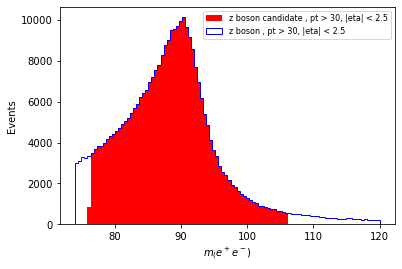

In [6]:
e1 = vector. VectorNumpy4D(
        {
            "x":l_pt,
            "y":l_phi,
            "z":l_eta,
            "t":l_energy,
        }
)

e2 = vector. VectorNumpy4D(
         {
            "x":r_pt,
            "y":r_phi,
            "z":r_eta,
            "t":r_energy,
             
             
             
         }
)
print("e1",e1)

print("e2",e2)

print("lene1",len(e1))

zcond = e1 + e2

zcondmag=zcond.mag
 

print("zcond",zcond)

print("zcondmag",zcondmag)

z=[]
i=1
for i in range (1,len(zcondmag)):
    if abs(zcondmag[i] - 91.19)<15:
        z.append(abs(zcondmag[i]))

print("N",len(z))
print("nn",len(zcondmag))


plt.hist(z, range=(74,120), bins=100, color='red',label="z boson candidate , pt > 30, |eta| < 2.5")
plt.hist(zcondmag, range=(74,120), bins=100,color='blue',histtype="step",label="z boson , pt > 30, |eta| < 2.5")


plt.xlabel("$m_(e^+ e^-)$")
plt.ylabel("Events")
plt.legend(loc=1,fontsize=8)

In [17]:
import itertools
j=0
sub=[]
for j in range(len(z)):
    x =np.array(np.where(zcondmag==z[j]))
    sub.append(x)
o = ak.flatten(sub)
flat_list = list(itertools.chain.from_iterable(o))


i=0
pu=[]
for i in range(len(flat_list)):
    r = c[flat_list[i]]
    pu.append(r)
        


k=0
pv=[]
for k in range(len(flat_list)):
    rr = d[flat_list[k]]
    pv.append(rr)



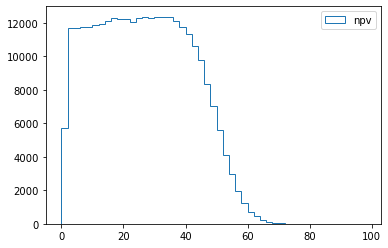

In [8]:
plt.hist(pv,bins=range(0,100,2),histtype="step", label="npv")
plt.legend()

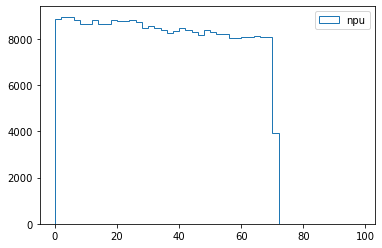

In [9]:
plt.hist(pu,bins=range(0,100,2),histtype="step",label="npu")
plt.legend()


In [ ]:
trigger = vector.VectorNumpy2D(
              {
                  "x":l_hlt,
                  "y":r_hlt,
              }

)
print("trigger",trigger)

i=0
H=[]
for i in range(len(flat_list)):
    r = trigger[flat_list[i]]
    H.append(r)
print("H",H[5]) 
print(H[5].rho)
print(len(H))

In [11]:
ii=0
two_fail=[]
non=[]
for ii in range(len(H)):
    if(H[ii] == vector.obj(x=0,y=0)):
        non.append(ii)
        two_fail.append(H[ii])

Text(0, 0.5, 'N0')

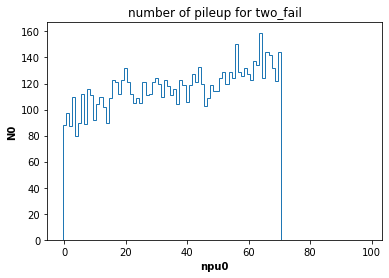

In [12]:
ff=0
npu0=[]
for ff in range(len(non)):
    yy = pu[non[ff]]
    npu0.append(yy)
    
    
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c) 
    
graph5,bins = np.histogram(npu0,bins)
plt.hist(npu0,bins,histtype="step")
plt.title("number of pileup for two_fail")
plt.xlabel("npu0",fontweight='bold')
plt.ylabel("N0",fontweight='bold')


Text(0, 0.5, 'N0')

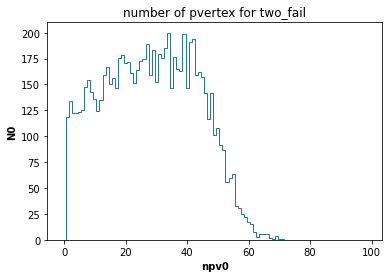

In [13]:
fff=0
npv0=[]
for fff in range(len(non)):
    yyy = pv[non[fff]]
    npv0.append(yyy)
    
    
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c) 
    
graph6,bins = np.histogram(npv0,bins)
plt.hist(npv0,bins,histtype="step")
plt.title("number of pvertex for two_fail")
plt.xlabel("npv0",fontweight='bold')
plt.ylabel("N0",fontweight='bold')


In [14]:
j=0
one_pass=[]
suu=[]
for j in range(len(H)):
    if((H[j]==vector.obj(x=0,y=1)) or(H[j]==vector.obj(x=1,y=0)) or (H[j]==vector.obj(x=0,y=3)) or (H[j]==vector.obj(x=3,y=0))):
        suu.append(j)
        one_pass.append(H[j])
        

Text(0, 0.5, 'N1')

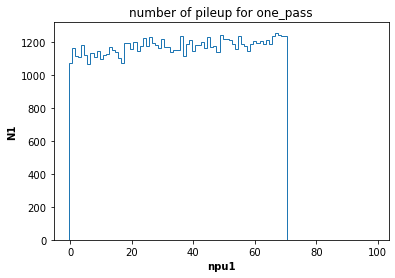

In [15]:
l=0
npu1=[]
for l in range(len(suu)):
    y = pu[suu[l]]
    npu1.append(y)
    
    
    
    
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c) 
    
graph1,bins = np.histogram(npu1,bins)
plt.hist(npu1,bins,histtype="step")
plt.title("number of pileup for one_pass")
plt.xlabel("npu1",fontweight='bold')
plt.ylabel("N1",fontweight='bold')

Text(0, 0.5, 'N1')

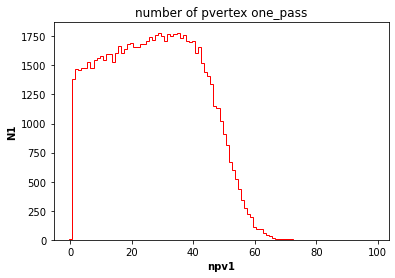

In [16]:
t=0
npv1=[]
for t in range(len(suu)):
    w = pv[suu[t]]
    npv1.append(w)

    
    
    
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)    
    
graph2,bins = np.histogram(npv1,bins)
plt.hist(npv1,bins,histtype="step",color="red")
plt.title("number of pvertex one_pass")
plt.xlabel("npv1",fontweight='bold')
plt.ylabel("N1",fontweight='bold')


In [17]:
n=0
two_pass=[]
sus=[]
for n in range(len(H)):
    if((H[n] == vector.obj(x=3,y=3)) or (H[n] == vector.obj(x=3,y=1)) or (H[n] == vector.obj(x=1,y=3)) or (H[n] == vector.obj(x=1,y=1))):
        sus.append(n)
        two_pass.append(H[n])

Text(0, 0.5, 'N2')

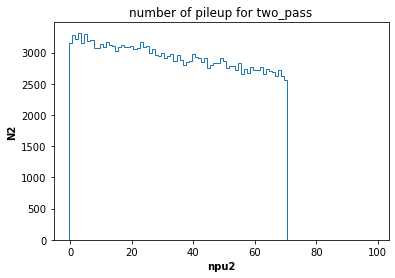

In [18]:
v=0
npu2=[]
for v in range(len(sus)):
    q = pu[sus[v]]
    npu2.append(q)

    
    
    
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c) 
    
graph3,bins= np.histogram(npu2,bins)

plt.hist(npu2,bins,histtype="step")
plt.title("number of pileup for two_pass")
plt.xlabel("npu2",fontweight='bold')
plt.ylabel("N2",fontweight='bold')


Text(0, 0.5, 'N2')

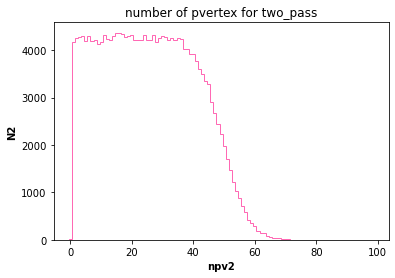

In [19]:
u=0
npv2=[]
for u in range(len(sus)):
    b = pv[sus[u]]
    npv2.append(b)

    
    
    
    
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)    
    
graph4 ,bins = np.histogram(npv2,bins)
plt.hist(npv2,bins,histtype="step",color='hotpink')
plt.title("number of pvertex for two_pass")
plt.xlabel("npv2",fontweight='bold')
plt.ylabel("N2",fontweight='bold')


300041


Text(0, 0.5, 'N')

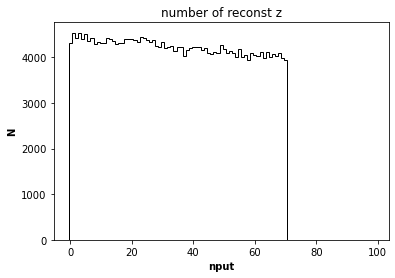

In [20]:
nput = npu0+npu1+npu2
print(len(nput))
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)   
    
    
graph ,bins = np.histogram(nput,bins)
plt.hist(nput,bins,histtype="step",color='black')
plt.title("number of reconst z")
plt.xlabel("nput",fontweight='bold')
plt.ylabel("N",fontweight='bold')


300041


Text(0, 0.5, 'N')

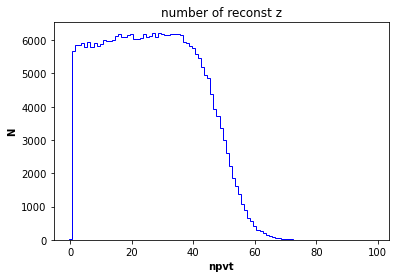

In [21]:
npvt = npv0+npv1+npv2
print(len(npvt))
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)   
    
    
graphh ,bins = np.histogram(npvt,bins)
plt.hist(npvt,bins,histtype="step",color='blue')
plt.title("number of reconst z")
plt.xlabel("npvt",fontweight='bold')
plt.ylabel("N",fontweight='bold')

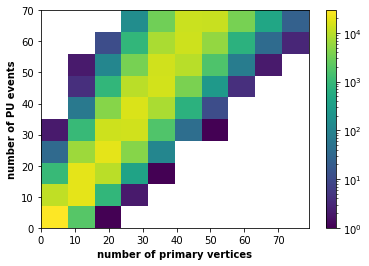

In [22]:
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)   
    
from matplotlib.colors import LogNorm  

graphh ,bins = np.histogram(npvt,bins)
graph ,bins = np.histogram(nput,bins)
plt.hist2d(npvt,nput,norm=LogNorm())
plt.xlabel("number of primary vertices",fontweight='bold')
plt.ylabel("number of PU events",fontweight='bold')
plt.colorbar()


[0.96333182 1.00087565 1.00131128 0.99955196 0.99922228 0.99878981
 0.99818179 1.00311476 1.00198863 0.99922376 0.997729   0.99774226
 0.99743235 1.00127294 1.00509978 1.0004296  0.99950285 0.99968119
 1.00297956 1.00214314 1.00094546 1.00160254 0.99948514 0.99710735
 1.0000808  0.99996205 0.99927043 1.00298377 0.99560378 0.99963536
 0.99580502 1.00125418 0.99840473 1.00057071 1.00221515 0.99366534
 0.99999973 0.99546003 0.99695563 1.0024709  0.99304699 1.00371316
 1.00048998 0.99872602 1.00122021 1.00139081 0.99725494 0.99805188
 1.00295981 0.99507143 1.00146608 0.99843153 1.00451034 0.99046929
 0.99529023 1.00774879 0.99205948 0.99858583 0.99327662 0.99082951
 1.01574394 1.00826446 0.98061208 0.98114344 1.0050755  1.01553201
 1.05981096 1.03450327 1.00819156 1.07958478 1.04081633 0.99382716
 0.83044983 1.         0.88888889 1.         1.         1.        ]


/tmp/ipykernel_551/3647178741.py:1: RuntimeWarning: invalid value encountered in long_scalars
  ooutput = np.array([ (z/y) * pow(((2 * y) / ((2 * y) + x) ),2)  for x, y , z in zip(graph2,graph4,graphh)])
/tmp/ipykernel_551/3647178741.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  ooutput = np.array([ (z/y) * pow(((2 * y) / ((2 * y) + x) ),2)  for x, y , z in zip(graph2,graph4,graphh)])
/tmp/ipykernel_551/3647178741.py:1: RuntimeWarning: invalid value encountered in double_scalars
  ooutput = np.array([ (z/y) * pow(((2 * y) / ((2 * y) + x) ),2)  for x, y , z in zip(graph2,graph4,graphh)])


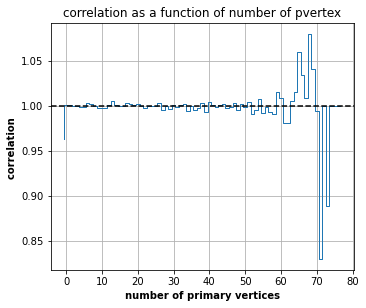

In [26]:
ooutput = np.array([ (z/y) * pow(((2 * y) / ((2 * y) + x) ),2)  for x, y , z in zip(graph2,graph4,graphh)])
ooutput = ooutput[:78]
bins=[]
print(ooutput)
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)  
bins = bins[:78]    
fig = plt.figure(figsize=(25, 10))
ax1 = plt.subplot2grid((2,4), (0,2)) 
ax1.step(bins,ooutput, lw=1)

plt.axhline(y = 1, color = 'black', linestyle = 'dashed')   
ax1.set_title("correlation as a function of number of pvertex")
plt.xlabel("number of primary vertices",fontweight='bold')
plt.ylabel("correlation ",fontweight='bold')
plt.grid()
plt.show()


/tmp/ipykernel_551/2783447158.py:1: RuntimeWarning: invalid value encountered in long_scalars
  out = np.array([ (z/y) * pow(((2 * y) / ((2 * y) + x) ),2)  for x, y , z in zip(graph1,graph3,graph)])


[0.9991137  0.99850754 0.99775415 1.00375359 0.99301111 0.99872319
 1.00520358 0.99751452 1.0035735  1.00104319 0.99902892 1.00034851
 1.0021331  0.99831154 0.99606644 1.00042253 1.00550235 1.00671352
 0.9990828  1.00180914 1.00547104 1.00072273 1.00118887 0.99897379
 0.99722439 0.99863063 0.99867836 0.99868603 0.99852348 1.00134898
 0.99986995 1.00036909 0.99858157 1.00322763 1.00063874 0.99959564
 0.99582111 0.99836071 0.9996119  0.9976615  0.99897796 0.99990244
 1.00148065 0.99858313 1.00399304 0.99576728 0.99524351 0.99668813
 1.00114378 0.99558168 0.99612791 0.99718195 0.99909672 0.99836779
 1.00125205 0.99735288 1.00404831 1.00062082 1.00078082 1.00085317
 0.99829643 0.99793965 1.00123557 1.00010209 1.00602387 0.99835471
 1.0002961  0.99777903 0.99750702 0.99393424 0.99853288]


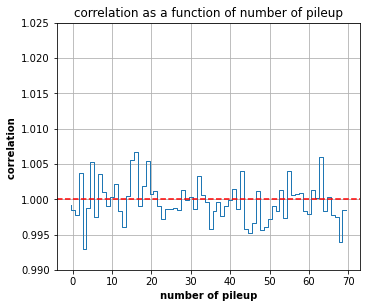

In [24]:
out = np.array([ (z/y) * pow(((2 * y) / ((2 * y) + x) ),2)  for x, y , z in zip(graph1,graph3,graph)])
out = out[:71]
bins=[]
print(out)
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)  
bins = bins[:71] 

fig = plt.figure(figsize=(25, 10))
ax2 = plt.subplot2grid((2,4), (0,2)) 
ax2.step(bins,out, lw=1)
plt.ylim([0.990, 1.025])
plt.axhline(y = 1, color = 'r', linestyle = 'dashed')   
ax2.set_title("correlation as a function of number of pileup")
plt.title("correlation as a function of number of pileup")
plt.xlabel("number of pileup",fontweight='bold')
plt.ylabel("correlation ",fontweight='bold')
plt.grid()
plt.show()

/tmp/ipykernel_551/2566373990.py:1: RuntimeWarning: invalid value encountered in long_scalars
  output1 = np.array([(2*y)/((2*y)+x) for x, y in zip(graph1,graph3)])


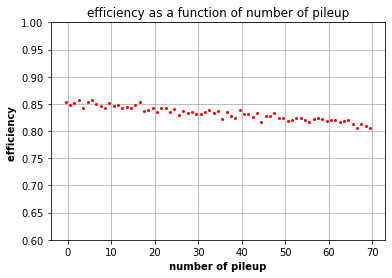

In [46]:
output1 = np.array([(2*y)/((2*y)+x) for x, y in zip(graph1,graph3)])
output1 = output1[:71]
bins = bins[:71]
plt.plot(bins,output1,'o',markersize=2,color='red')
plt.ylim([0.6, 1])
plt.title("efficiency as a function of number of pileup")
plt.xlabel("number of pileup",fontweight='bold')
plt.ylabel("efficiency ",fontweight='bold')
plt.grid()


/tmp/ipykernel_551/1266898128.py:1: RuntimeWarning: invalid value encountered in long_scalars
  output2 = np.array([(2*y)/((2*y)+x) for x, y in zip(graph2,graph4)])


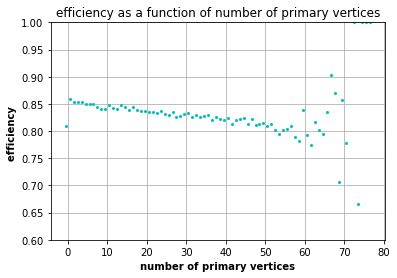

In [45]:
output2 = np.array([(2*y)/((2*y)+x) for x, y in zip(graph2,graph4)])
bins=[]
i=0
for i in range(0,100):
    c=i-0.5
    bins.append(c)
    
output2 = output2[:78]
bins = bins[:78]
plt.plot(bins,output2,'o',markersize=2,color='c')
plt.ylim([0.6, 1])
plt.title("efficiency as a function of number of primary vertices")
plt.xlabel("number of primary vertices",fontweight='bold')
plt.ylabel("efficiency ",fontweight='bold')
plt.grid()

len(trigger) 300041
len(two_fail) 8319
len(one_pass) 83448
len(two_pass) 208274


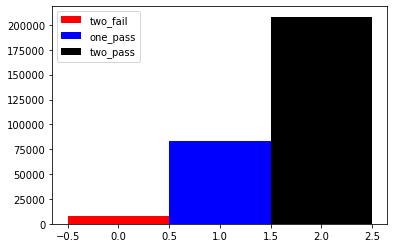

In [28]:
print("len(trigger)",len(H))                
print("len(two_fail)",len(two_fail))
print("len(one_pass)",len(one_pass))
print("len(two_pass)",len(two_pass))

i=0
j=0
n=0
zero=[]
one=[]
two=[]

for i in range(len(two_fail)):
    two_fail[i]=0
    zero.append(two_fail[i])
    
for j in range(len(one_pass)):
    one_pass[j]=1
    one.append(one_pass[j])
    
for n in range(len(two_pass)):
    two_pass[n]=2
    two.append(two_pass[n])
    

plt.hist(zero ,color='red',bins=1,label="two_fail") 
plt.hist(one,color='blue',bins=1,label="one_pass")
plt.hist(two , color='black',bins=1,label="two_pass")
plt.legend()

In [ ]:
### Approch 1

#N = number of reconstructed z boson
#effhlt = probability that one electron passing hlt
### N1 = 2*effhlt*(1-effhlt)*N
### N2 = effhlt*effhlt*N
### N0 = ((1-effhlt)^2 )*N

In [29]:
from sympy import symbols, solve
import math 

N0 = len(two_fail) 
N1 = len(one_pass) 
N2 = len(two_pass) 
N = 300041

eff = symbols('eff')
eq = (2*eff*(1-eff)*N) - N1
answer = solve(eq)
n = np.array(answer) 
print("effhlt",answer)
print(float(n[0]))
print(float(n[1]))

eff1 = symbols('eff1')
eq1 = (eff1*eff1*N) - N2
answe = solve(eq1)
n1 = np.array(answe)
print("eff1hlt",answe)
print(float(n1[0]))
print(float(n1[1]))

eff2 = symbols('eff2')
eq2 = (pow((1-eff2),2)*N) - N0
answ = solve(eq2)
n2 = np.array(answ)
print("eff2hlt",answ)
print(float(n2[0]))
print(float(n2[1]))
efff = (2*N2)/((2*N2)+N1)
u = N1+N0+N2
print(u)
print(efff)

effhlt [1/2 - sqrt(39948958945)/600082, sqrt(39948958945)/600082 + 1/2]
0.16692492587608776
0.8330750741239122
eff1hlt [-sqrt(62490739234)/300041, sqrt(62490739234)/300041]
-0.8331577277167282
0.8331577277167282
eff2hlt [1 - sqrt(2496041079)/300041, sqrt(2496041079)/300041 + 1]
0.833488106277067
1.166511893722933
300041
0.8331026648213186


In [30]:
##Correlation coefficient
#N2 = C * eff^2 * N
#N1 = 2 * eff * (1 - C * eff) * N
#N0 = (1 - 2 * eff + C * eff^2) * N
C = (N/N2) * pow((2 * N2 / (2 * N2 + N1) ),2)
print(C)

0.9998678255652174


In [31]:
cc = symbols('cc')
e = (cc *pow(efff,2) * N)-N2
an = solve(e)
print("correlation",an)

correlation [1.00013219190717]


In [32]:
ccc = symbols('ccc')
ll = (2 * efff * (1 - ccc * efff) * N)-N1
ana = solve(ll)
print("correlation",ana)

correlation [0.999973517697194]


In [33]:
cccc = symbols('cccc')
pp = ((1 - (2 * efff) + (cccc * pow(efff,2))) * N)-N0
anaa = solve(pp)
print("correlation",anaa)

correlation [0.999814843487210]
